In [48]:
import os
import sys

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.helper import get_root_dir, set_seed, setup_gpu
from utils.data import load_data
from utils.plots import plot_reconstructions, plot_history
from utils.latent_space import plot_latent_space
from utils.evaluation import evaluate_autoencoder
from utils.loss import ssim_loss, ssim_l1_loss, dssim_loss

In [49]:
# Hyperparameter to tune
config = {
    "comment" : "deep autoencoder",
    "epochs" : 100,
    "loss" : 'ssim_l1',
    "optimizer" : "adam",
    "dropout_value" : 0.3,
    "batch_norm": True,
    "batch_size" : 16,
    "latent_dim" : 512,
    "threshold_percentage" : 80,
    "data_class" : "screw",
    "model_type" : "autoencoder"
}

# Rather static parameters, no need to track
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [50]:
wandb.init(project="itu-aml-project", config=config)
config = wandb.config # this turns our hyperparameter config into a proper object with attributes

In [51]:
root_dir = get_root_dir()
#root_dir = 'Mini Project'
setup_gpu()
set_seed(1234)

model_dir = os.path.join(root_dir, 'models', config.model_type)

cpkt_path = os.path.join(model_dir, 'logs', 'checkpoints', f'{config.comment}_checkpoint.model.keras')
weights_path = os.path.join(model_dir, 'logs', 'weights', f'{config.comment}_model.keras')
assert not os.path.exists(weights_path), f'Path already exists: {weights_path}. Please change the comment.'

No GPU found, using CPU.


In [52]:
train_generator, validation_generator, test_generator = load_data(category=config.data_class, batch_size=config.batch_size)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 160 images belonging to 6 classes.


In [54]:
# https://github.com/plutoyuxie/AutoEncoder-SSIM-for-unsupervised-anomaly-detection-/blob/master/train.py
def deep_autoencoder(input_shape=(256, 256, 3), optimizer='adam', latent_dim=512, loss = 'mse', batch_norm=True, dropout_value=0.5):
    
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(input_img)
    if batch_norm: x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(32, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    if batch_norm: x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(32, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    if batch_norm: x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(64, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    if batch_norm: x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(64, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    if batch_norm: x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(128, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    if batch_norm: x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(64, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    if batch_norm: x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    x = Conv2D(32, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    if batch_norm: x = BatchNormalization()(x)
    x = Dropout(dropout_value)(x)

    encoded = Conv2D(latent_dim, (8, 8), strides=1, activation='linear', padding='valid')(x)

    # Decoder
    x = Conv2DTranspose(32, (8, 8), strides=1, activation=LeakyReLU(alpha=0.2), padding='valid')(encoded)
    x = Conv2D(64, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    x = Conv2D(128, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    x = Conv2DTranspose(64, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    x = Conv2D(64, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    x = Conv2DTranspose(32, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    x = Conv2D(32, (3, 3), strides=1, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    x = Conv2DTranspose(32, (4, 4), strides=2, activation=LeakyReLU(alpha=0.2), padding='same')(x)
    decoded = Conv2DTranspose(input_shape[2], (4, 4), strides=2, activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    return autoencoder

# get correct loss from config as functions are not callable from config itself
if config.loss == 'mae': loss = 'mae'
elif config.loss == 'mse': loss = 'mse'
elif config.loss == 'dssim': loss = dssim_loss
elif config.loss == 'ssim': loss = ssim_loss
elif config.loss == 'ssim_l1': loss = ssim_l1_loss
else:
    raise ValueError(f"Unknown loss function: {config.loss}. Please define a function to calculate the error.")

autoencoder = deep_autoencoder(
    input_shape=INPUT_SHAPE, 
    optimizer=config.optimizer, 
    latent_dim=config.latent_dim, 
    loss=loss,
    batch_norm = config.batch_norm,
    dropout_value = 0.3
)

print("Input shape:", autoencoder.input_shape)
print("Output shape:", autoencoder.output_shape)

autoencoder.summary()

Input shape: (None, 256, 256, 3)
Output shape: (None, 256, 256, 3)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 128, 128, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 64, 64, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,740,355 (10.45 MB)

 Trainable params: 2,739,459 (10.45 MB)

 Non-trainable params: 896 (3.50 KB)

In [55]:
#define early stopping and checkpoints
early_stop = EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=20, 
    start_from_epoch=20
    )

checkpoint = ModelCheckpoint(
    cpkt_path, 
    monitor="val_loss", 
    mode="min", 
    save_best_only=True, 
    verbose=1
    )

history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[
        early_stop,
        checkpoint,
        WandbMetricsLogger(),
        # WandbModelCheckpoint("models"), # Saves model checkpoint to W&B
    ],
)

wandb.finish()

/opt/conda/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.2470
Epoch 1: val_loss improved from inf to 0.23632, saving model to Mini Project/models/autoencoder/logs/checkpoints/deep autoencoder_checkpoint.model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - loss: 0.2465 - val_loss: 0.2363
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.1773
Epoch 2: val_loss improved from 0.23632 to 0.21338, saving model to Mini Project/models/autoencoder/logs/checkpoints/deep autoencoder_checkpoint.model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - loss: 0.1762 - val_loss: 0.2134
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.1234
Epoch 3: val_loss improved from 0.21338 to 0.18716, saving model to Mini Project/models/autoencoder/logs/checkpoints/deep autoencoder_checkpoint.model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - loss: 0.1233 - val_loss: 0.1872
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.1133
Epoch 4: val_loss did not improve fr

epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▇▆▆▆▆▅▅▄▄▃▃▄▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▁▂▂▁▂▁▁▂▂▂▂
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.06066
epoch/val_loss,0.07055


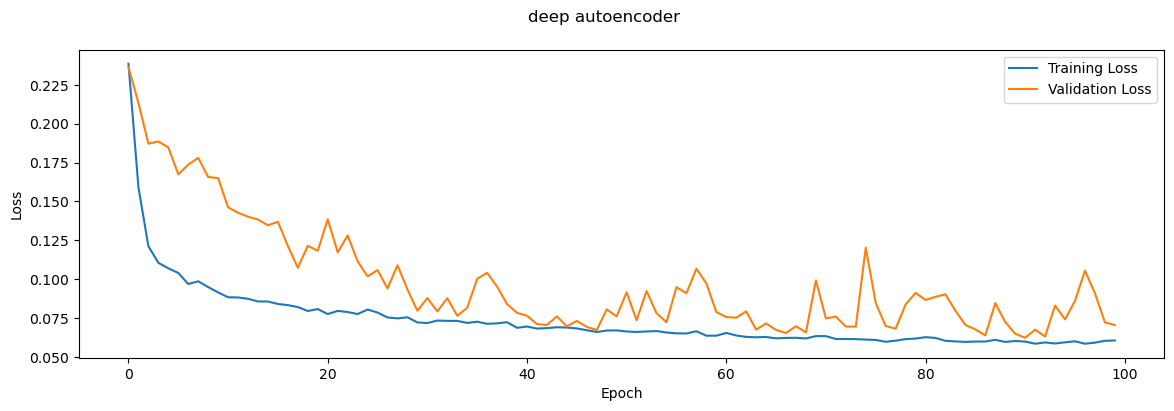

Best train_loss: 0.0586
Best val_loss: 0.0624
Last improvement of val_loss at epoch: 1


In [56]:
# plot the training history
plot_history(comment=config.comment, history=history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


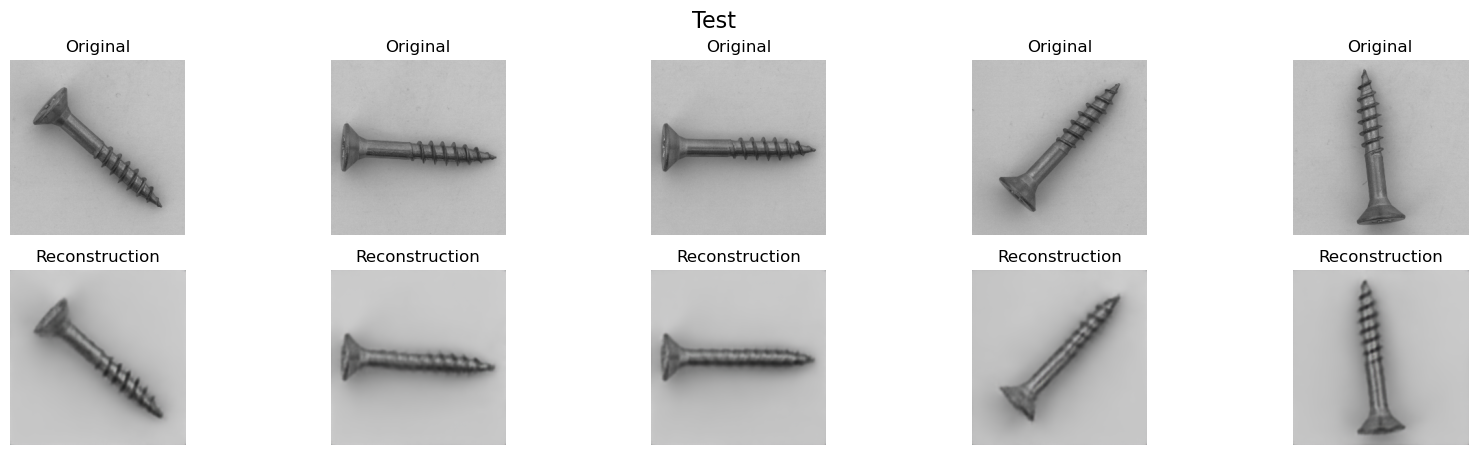

In [57]:
plot_reconstructions(autoencoder, test_generator, n_images=5, title='Test')


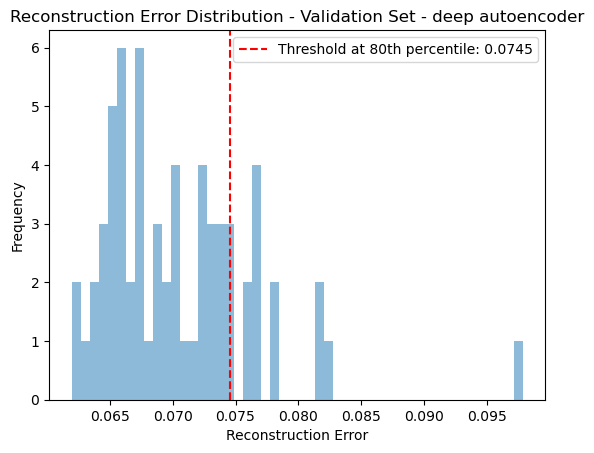

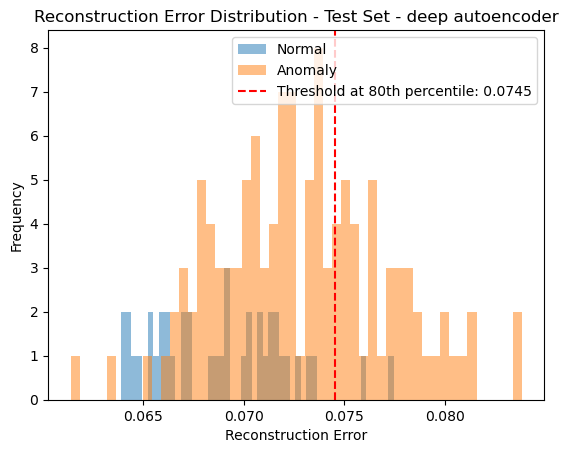

              precision    recall  f1-score   support

      Normal       0.33      0.95      0.49        41
     Anomaly       0.95      0.34      0.51       119

    accuracy                           0.50       160
   macro avg       0.64      0.65      0.50       160
weighted avg       0.79      0.50      0.50       160



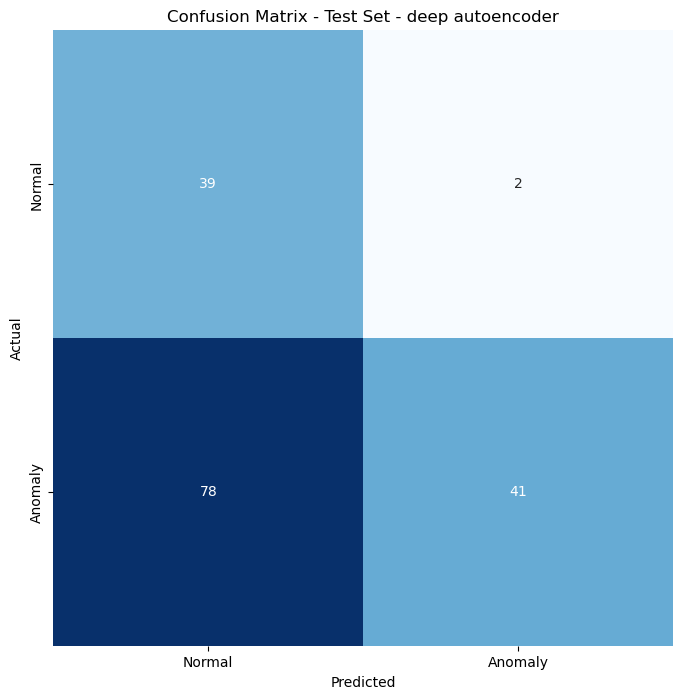

In [58]:
evaluate_autoencoder(
    config = config,
    autoencoder=autoencoder,
    validation_generator=validation_generator,
    test_generator=test_generator
    )

/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_64683/2744363305.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_classes)


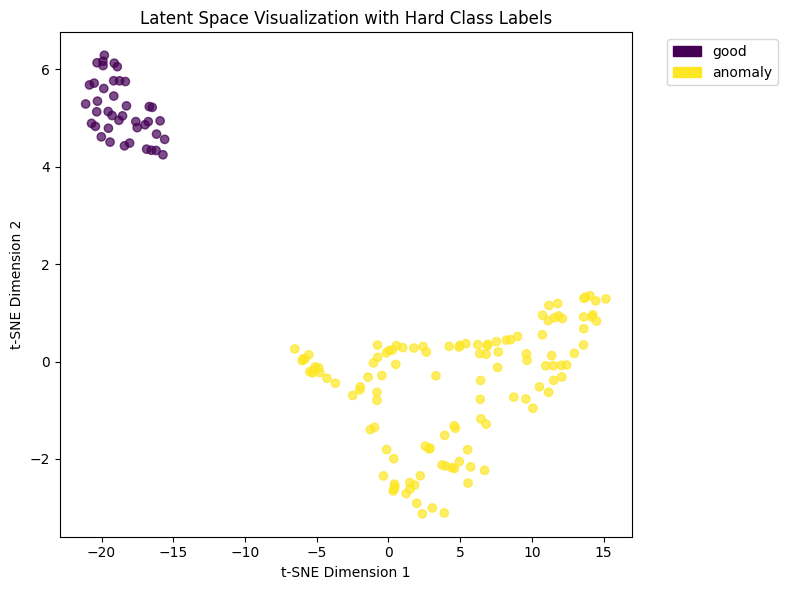

In [39]:
plot_latent_space(autoencoder, test_generator, layer_name='dense_2')

The file exists: ../../data/screw/test/manipulated_front/001.png
The file exists: ../../data/screw/test/scratch_head/001.png
The file exists: ../../data/screw/test/scratch_neck/001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


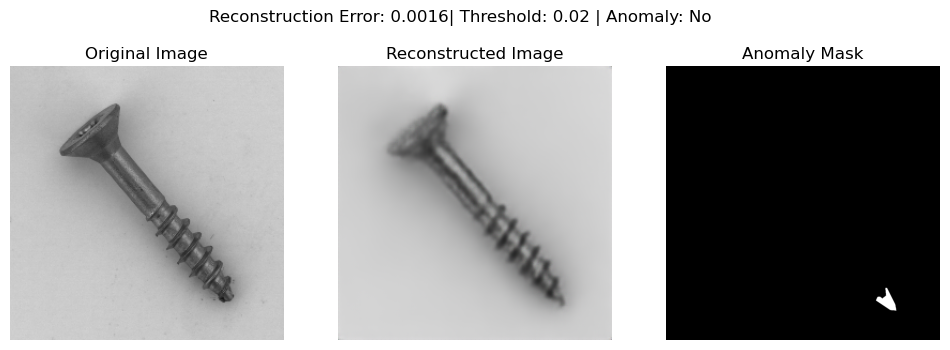

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


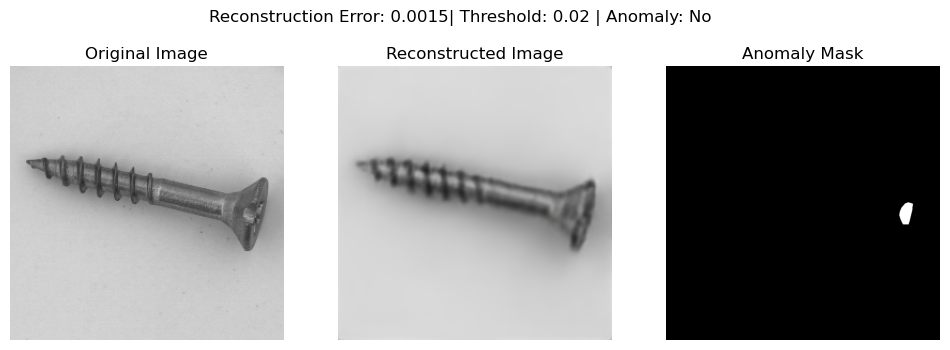

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


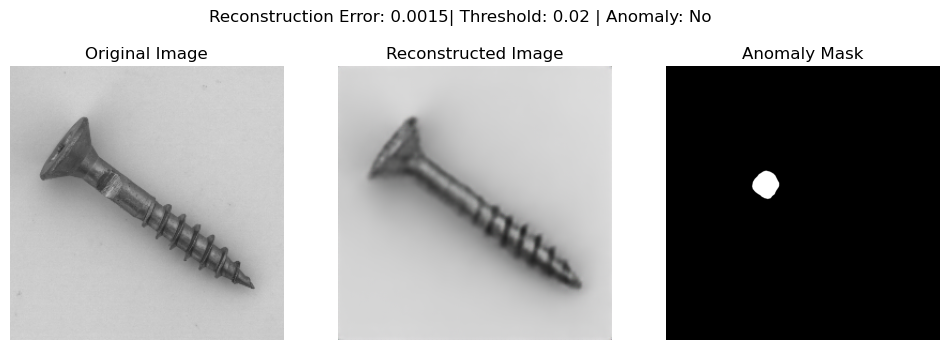

In [59]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def preprocess_image(image_path, target_size=(256, 256)):
    """Load and preprocess an image for the autoencoder."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0  # Normalize to [0, 1] and set to float32
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def calculate_reconstruction_error(original, reconstructed):
    """Calculate the mean squared error between original and reconstructed images."""
    return np.mean((original - reconstructed) ** 2)

def predict_anomaly_and_plot(autoencoder, image_path, mask_dir, threshold=0.02):
    """
    Predict if an image is an anomaly based on reconstruction error
    and plot original, reconstructed, and mask images.
    
    Parameters:
        autoencoder (Model): The trained autoencoder model.
        image_path (str): Path to the image file.
        mask_dir (str): Directory containing anomaly mask images.
        threshold (float): Error threshold to classify as anomaly.
    
    Returns:
        bool: True if anomaly, False otherwise.
        float: The reconstruction error.
    """
    # Preprocess the image
    img = preprocess_image(image_path)
    
    # Reconstruct the image with the autoencoder
    reconstructed_img = autoencoder.predict(img)

    # Ensure reconstructed image is in float32 format
    reconstructed_img = reconstructed_img.astype('float32')
    
    # Calculate reconstruction error
    error = calculate_reconstruction_error(img, reconstructed_img)
    
    # Classify as anomaly if error exceeds the threshold
    is_anomaly = error > threshold

    # Generate the corresponding mask path
    file_name = os.path.basename(image_path).split('.')[0] + '_mask.png'
    label = os.path.basename(os.path.dirname(image_path))
    mask_path = os.path.join(mask_dir, label, file_name)
    
    # Load the mask image if it exists
    if os.path.exists(mask_path):
        mask_img = plt.imread(mask_path)
    else:
        mask_img = None

    # Plot original, reconstructed, and mask images
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img[0])  # Remove batch dimension for display
    plt.title("Original Image")
    plt.axis("off")
    
    # Reconstructed image
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_img[0])  # Remove batch dimension for display
    plt.title("Reconstructed Image")
    plt.axis("off")
    
    # Anomaly mask
    plt.subplot(1, 3, 3)
    if mask_img is not None:
        plt.imshow(mask_img, cmap="gray")
        plt.title("Anomaly Mask")
    else:
        plt.text(0.5, 0.5, 'No Mask Available', ha='center', va='center', fontsize=12)
    plt.axis("off")
    
    plt.suptitle(f"Reconstruction Error: {error:.4f}| Threshold: {threshold} | Anomaly: {'Yes' if is_anomaly else 'No'}")
    plt.show()
    
    return is_anomaly, error

# Example usage
"""mask_dir = '../../data/screw/ground_truth'
image_paths = [
    '../../data/screw/test/manipulated_front/001.png',
    '../../data/screw/test/scratch_head/001.png', 
    '../../data/screw/test/scratch_neck/001.png' 
]"""
mask_dir = 'data/screw/ground_truth'
image_paths = [
    'data/screw/test/manipulated_front/001.png',
    'data/screw/test/scratch_head/001.png', 
    'data/screw/test/scratch_neck/001.png' 
]
for file_path in image_paths:
    if os.path.exists(file_path):
        print(f"The file exists: {file_path}")
    else:
        print(f"The file does not exist: {file_path}")

for path in image_paths: 
    is_anomaly, error = predict_anomaly_and_plot(autoencoder, path, mask_dir)
